<a href="https://colab.research.google.com/github/lhmin0614/MadCamp_week1_Android/blob/master/Q3_PCA_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.0x
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import time
from sklearn.metrics import confusion_matrix
import seaborn as sn

drive.mount('/content/drive')
mat = loadmat('/content/drive/MyDrive/CS492_teamProject/face.mat')

X = mat['X']
y = mat['l'][0]

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.0x`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
Mounted at /content/drive


In [2]:
#8:2 train:test split
train_X = [i[[True, True, True, True, False]*104] for i in X]         
test_X  = [i[[False, False, False, False, True]*104] for i in X]      
train_y = y[[True, True, True, True, False]*104]
test_y  = y[[False, False, False, False, True]*104]

print("<<Data dimension>>")
print("train_X : ", len(train_X)," * ", len(train_X[0]))
print("test_X  : ", len(test_X)," * ",  len(test_X[0]))
print("train_y : ", len(train_y))
print("test_y  : ", len(test_y))

<<Data dimension>>
train_X :  2576  *  416
test_X  :  2576  *  104
train_y :  416
test_y  :  104


In [3]:
avg_X = [ sum(i)/len(i) for i in train_X ]   

def PCA(Mpca):
  sub_X = [ list(np.asarray(x) - x_bar) for x, x_bar in zip(train_X, avg_X) ]
  A = np.matrix(sub_X)
  S = np.dot(A, A.T)
  eigvals, eigvecs_column = np.linalg.eigh(S) 
  eigvecs = eigvecs_column.T
  best_eigvals = eigvals[-Mpca:]
  best_eigvecs = eigvecs[-Mpca:]
  W = np.dot(A.T, np.matrix(best_eigvecs).T).T 
  return W, best_eigvecs

In [4]:
def LDA(Mlda, best_eigvecs):
  class_mean  = []
  global_mean = avg_X
  for i in range (52):
    class_mean.append([ sum(j)/len(j) for j in np.asarray(np.matrix(train_X)[:,i*8:(i+1)*8]) ])   

  between_diff = []
  within_diff = []
  for i in range(52):
    between_diff.append([a - b for a, b in zip(class_mean[i], global_mean)])
  for i in range(416):
    within_diff.append(np.subtract(np.asarray(np.matrix(train_X).T)[i],class_mean[i//8]))

  W =  np.matrix(best_eigvecs).T
  Sb = np.dot( np.matrix(between_diff).T, np.matrix(between_diff) )     #52 is the number of samples in class ci
  Sw = np.dot( np.matrix(within_diff).T , np.matrix(within_diff) )
  reduced_Sb = np.dot(np.dot(W.T, Sb), W)
  reduced_Sw = np.dot(np.dot(W.T, Sw), W)
  matrix_LDA = np.dot( np.linalg.inv(reduced_Sw), reduced_Sb )

  fisher_eigvals, fisher_eigvecs = np.linalg.eigh(matrix_LDA) 
  fisherface = fisher_eigvecs.T
  fisherface  = np.asarray(fisherface)[-Mlda:] 
  return fisherface

In [5]:
from sklearn.neighbors import KNeighborsClassifier

def projection(X,  P) :
  W = np.dot(np.matrix(X).T, P)
  return W


def NN_classification(Mpca, Mlda):
  #PCA
  W, best_eigvecs = PCA(Mpca)
  A = np.matrix([ list(np.asarray(x) - x_bar) for x, x_bar in zip(train_X, avg_X) ])
  prj_X  = projection(A, np.matrix(best_eigvecs).T)
  B = np.matrix([ list(np.asarray(x) - x_bar) for x, x_bar in zip(test_X, avg_X) ])
  validation_X = projection(B, np.matrix(best_eigvecs).T)

  #LDA
  fisherface = LDA(Mlda, best_eigvecs)
  prj_X_LDA = projection(prj_X.T, np.matrix(fisherface).T)
  validation_X_LDA = projection(validation_X.T, np.matrix(fisherface).T)

  #kNN
  classifier_LDA = KNeighborsClassifier(n_neighbors = 1)
  classifier_LDA.fit(prj_X_LDA.tolist(), train_y)
  train_accuracy = (classifier_LDA.score(prj_X_LDA.tolist(), train_y))
  test_accuracy = (classifier_LDA.score(validation_X_LDA.tolist(), test_y))

  return (train_accuracy, test_accuracy)

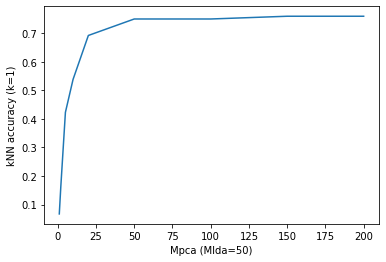

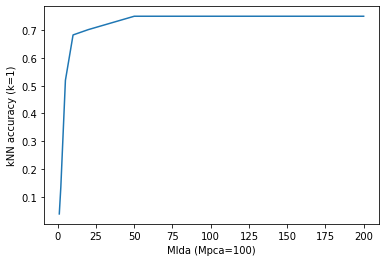

In [6]:
pca_cand = [1, 2, 5, 10, 20, 50, 100, 150, 200]
lda_cand = [1, 2, 5, 10, 20, 50, 100, 150, 200]

# change Mpca value 
Mpca_change_train = []
Mpca_change_test = []
for i in pca_cand:
  train, test = NN_classification(i, 50)
  Mpca_change_train.append(train)
  Mpca_change_test.append(test)

plt.xlabel("Mpca (Mlda=50)")
plt.ylabel("kNN accuracy (k=1)")
plt.plot(lda_cand, Mpca_change_test)
plt.show()

# change Mlda value
Mlda_change_train = []
Mlda_change_test = []
for j in lda_cand:
  train, test = NN_classification(100, j)
  Mlda_change_test.append(test)

plt.xlabel("Mlda (Mpca=100)")
plt.ylabel("kNN accuracy (k=1)")
plt.plot(lda_cand, Mlda_change_test)
plt.show()

PCA time: 4.61076021194458s
LDA additional time: 1.8418149948120117s


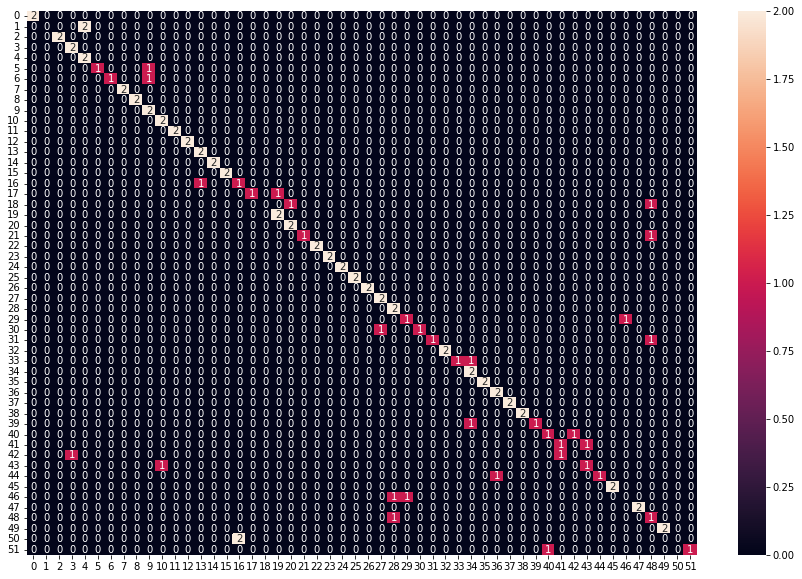

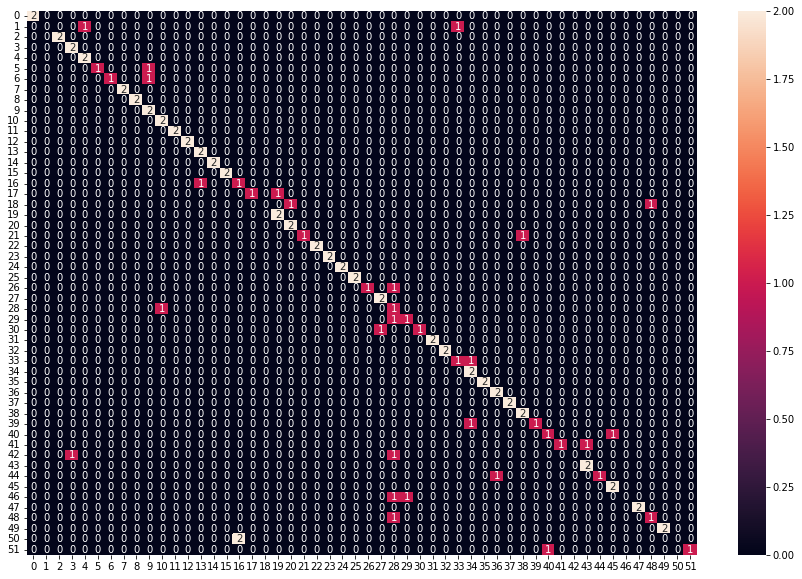

In [ ]:
#comparison of PCA and LDA
Mpca = 100
Mlda = 50

#PCA
start = time.time()
W, best_eigvecs = PCA(Mpca)
A = np.matrix([ list(np.asarray(x) - x_bar) for x, x_bar in zip(train_X, avg_X) ])
prj_X  = projection(A, np.matrix(best_eigvecs).T)
B = np.matrix([ list(np.asarray(x) - x_bar) for x, x_bar in zip(test_X, avg_X) ])
validation_X = projection(B, np.matrix(best_eigvecs).T)
stop = time.time()
print(f"PCA time: {stop - start}s")

#kNN for PCA
classifier_PCA = KNeighborsClassifier(1)
classifier_PCA.fit(prj_X.tolist(), train_y)
preds_pca=classifier_PCA.predict(validation_X)
print("<PCA confusion matrix>")
plt.figure(figsize = (15,10))
plt.xlabel("predicted class")
plt.ylabel("actual class")
sn.heatmap(confusion_matrix(test_y, preds_pca), annot=True)

#LDA
start = time.time()
fisherface = LDA(Mlda, best_eigvecs)
train_accuracy = []
test_accuracy = []
k=[]
prj_X_LDA = projection(prj_X.T, np.matrix(fisherface).T)
validation_X_LDA = projection(validation_X.T, np.matrix(fisherface).T)
stop = time.time()
print(f"LDA additional time: {stop - start}s")

#kNN for PCA-LDA
classifier_LDA = KNeighborsClassifier(1)
classifier_LDA.fit(prj_X_LDA.tolist(), train_y)
preds_pcalda=classifier_LDA.predict(validation_X_LDA)
print("<PCA-LDA confusion matrix>")
plt.figure(figsize = (15,10))
plt.xlabel("predicted class")
plt.ylabel("actual class")
sn.heatmap(confusion_matrix(test_y, preds_pcalda), annot=True)